<a href="https://colab.research.google.com/github/mathengem/Algorithmic-Trading-Backtesting-in-python/blob/main/1_NN_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 3.3 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=006a8011f4afdb4b1a545cfb0495f87542cf9e4957b56bd12ca9106635d9ec01
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [5]:
init_df

,open,high,low,close,adjclose,volume,ticker
2021-06-17,120.697502,122.522499,120.500000,121.743500,121.603935,25842000,GOOGL
2021-06-18,121.366997,121.602997,120.014999,120.111000,119.973305,46116000,GOOGL
2021-06-21,120.500504,122.000000,119.898499,121.812500,121.672859,27414000,GOOGL
2021-06-22,121.750000,122.400002,121.064003,122.330498,122.190262,22390000,GOOGL
2021-06-23,122.093498,123.095497,121.834503,122.126999,121.986992,19148000,GOOGL
...,...,...,...,...,...,...,...
2024-06-17,175.460007,178.360001,174.809998,177.240005,177.240005,19618500,GOOGL
2024-06-18,177.139999,177.389999,174.100006,175.089996,175.089996,21869900,GOOGL
2024-06-20,175.369995,177.289993,174.990005,176.300003,176.300003,20160100,GOOGL
2024-06-21,177.000000,180.850006,176.610001,179.630005,179.630005,58582700,GOOGL


In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [7]:
init_df

,close,date
2021-06-17,121.743500,2021-06-17
2021-06-18,120.111000,2021-06-18
2021-06-21,121.812500,2021-06-21
2021-06-22,122.330498,2021-06-22
2021-06-23,122.126999,2021-06-23
...,...,...
2024-06-17,177.240005,2024-06-17
2024-06-18,175.089996,2024-06-18
2024-06-20,176.300003,2024-06-20
2024-06-21,179.630005,2024-06-21


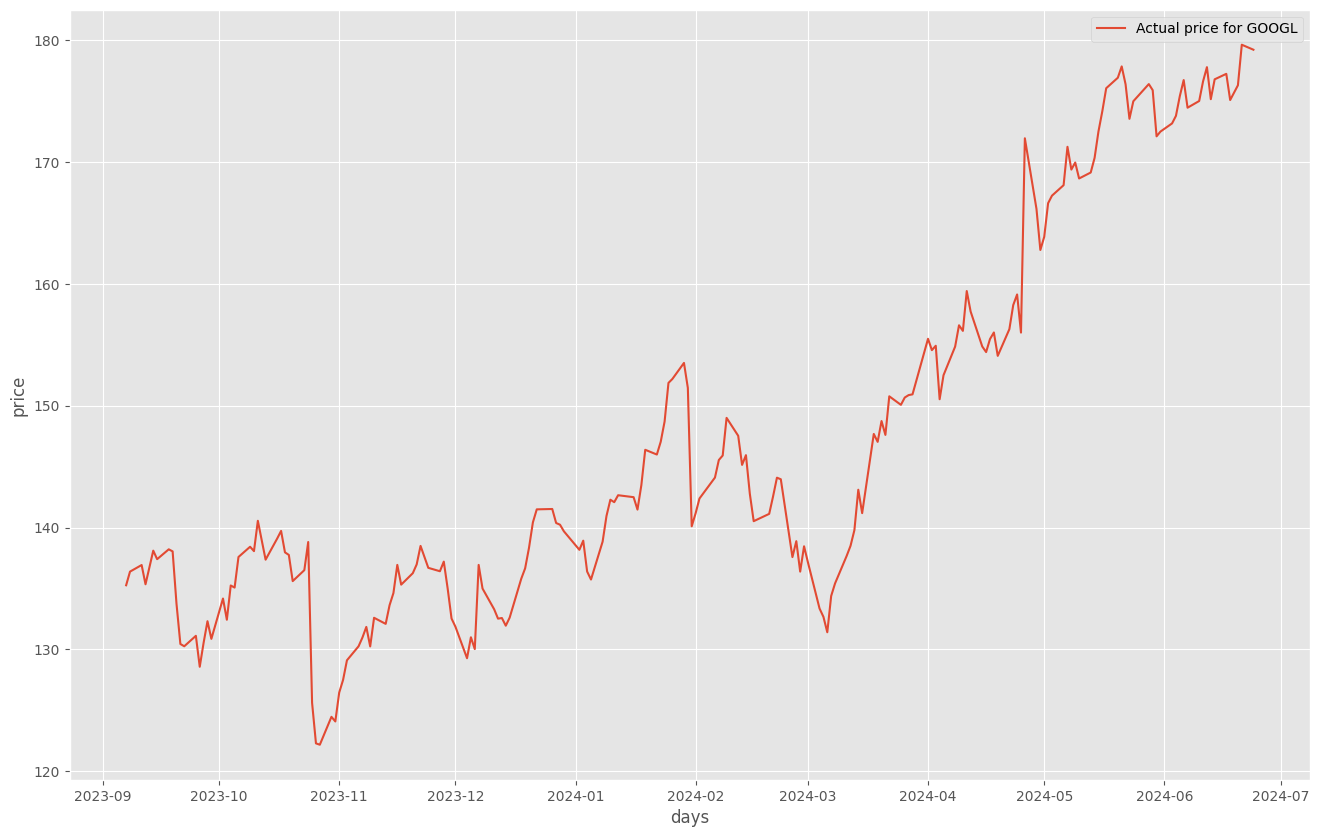

In [8]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [9]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [10]:
init_df

,close,date,scaled_close
2021-06-17,121.743500,2021-06-17,0.398269
2021-06-18,120.111000,2021-06-18,0.381299
2021-06-21,121.812500,2021-06-21,0.398986
2021-06-22,122.330498,2021-06-22,0.404371
2021-06-23,122.126999,2021-06-23,0.402256
...,...,...,...
2024-06-17,177.240005,2024-06-17,0.975156
2024-06-18,175.089996,2024-06-18,0.952807
2024-06-20,176.300003,2024-06-20,0.965385
2024-06-21,179.630005,2024-06-21,1.000000


In [11]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [12]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2021-06-17  121.743500 2021-06-17      0.398269  0.404371
 2021-06-18  120.111000 2021-06-18      0.381299  0.402256
 2021-06-21  121.812500 2021-06-21      0.398986  0.406133
 2021-06-22  122.330498 2021-06-22      0.404371  0.406221
 2021-06-23  122.126999 2021-06-23      0.402256  0.406507
 ...                ...        ...           ...       ...
 2024-06-12  177.789993 2024-06-12      0.980873  0.975156
 2024-06-13  175.160004 2024-06-13      0.953534  0.952807
 2024-06-14  176.789993 2024-06-14      0.970478  0.965385
 2024-06-17  177.240005 2024-06-17      0.975156  1.000000
 2024-06-18  175.089996 2024-06-18      0.952807  0.995738
 
 [756 rows x 4 columns],
 array([[0.9519749 ],
        [0.9687109 ],
        [0.98087305],
        [0.9535343 ],
        [0.97047806],
        [0.97515595],
        [0.9528066 ],
        [0.9653846 ],
        [1.        ],
        [0.995738  ]], dtype=float32),
 array([[[0.3982692061076076

In [13]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [14]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
94/94 [==============================] - 5s 9ms/step - loss: 0.0160
Epoch 2/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0042
Epoch 3/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0038
Epoch 4/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 5/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0031
Epoch 6/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 7/80
94/94 [==============================] - 1s 12ms/step - loss: 0.0029
Epoch 8/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0028
Epoch 9/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0026
Epoch 10/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0028
Epoch 11/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 12/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 13/80
94/94 [==========================

In [15]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

GOOGL prediction for upcoming 3 days (178.53$, 183.23$, 181.45$)


In [16]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 7ms/step


In [17]:
copy_df

,close,date,scaled_close,predicted_close
2021-06-17,121.743500,2021-06-17,0.398269,122.089500
2021-06-18,120.111000,2021-06-18,0.381299,122.444504
2021-06-21,121.812500,2021-06-21,0.398986,125.257500
2021-06-22,122.330498,2021-06-22,0.404371,126.190002
2021-06-23,122.126999,2021-06-23,0.402256,126.473999
...,...,...,...,...
2024-06-17,177.240005,2024-06-17,0.975156,179.679367
2024-06-18,175.089996,2024-06-18,0.952807,178.733810
2024-06-20,176.300003,2024-06-20,0.965385,176.300003
2024-06-21,179.630005,2024-06-21,1.000000,179.630005


In [18]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

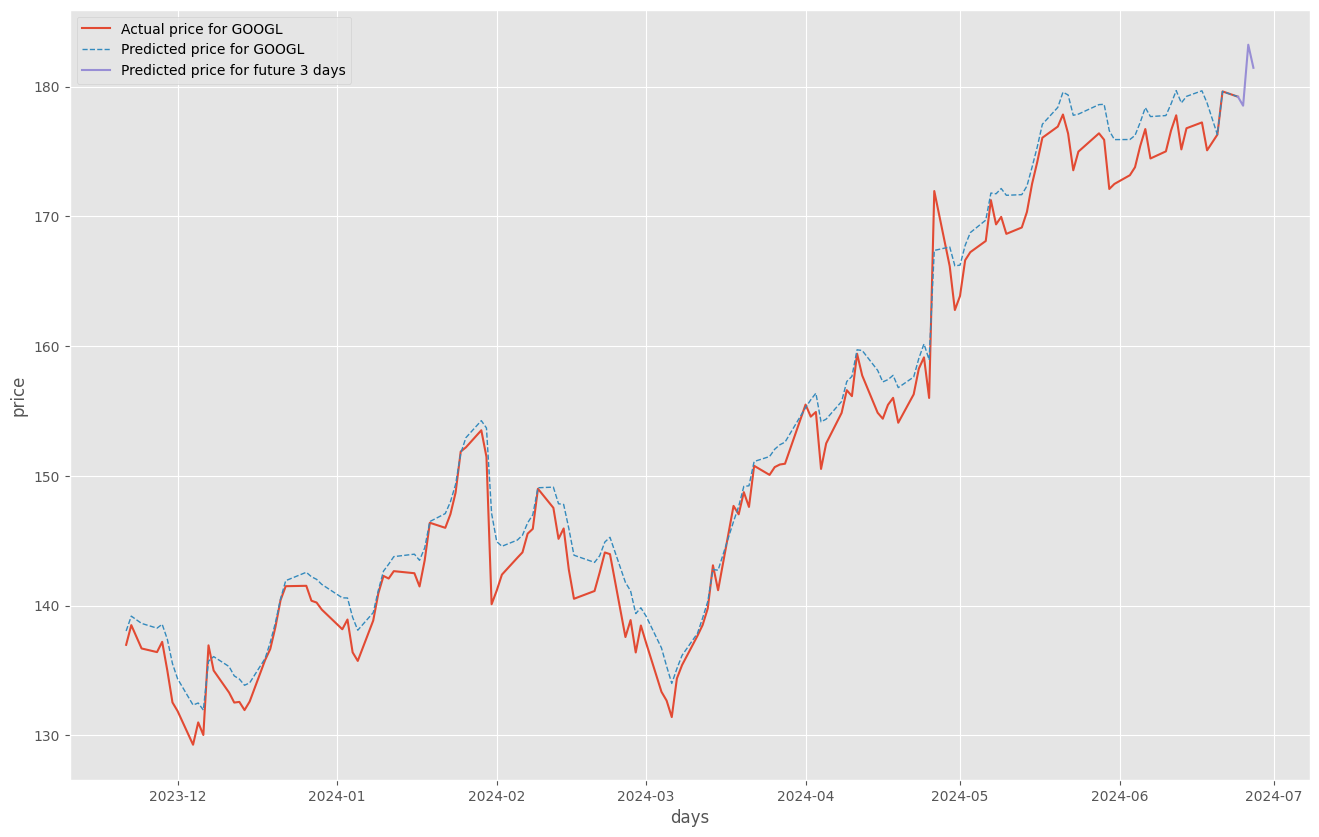

In [19]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()